> Created on Mon Jan 30 18:25:14 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

## 2.10.3 全景图与视域景观指数计算

### 2.10.3.1 全景静态图检索下载

#### 1）构建采样点




In [1]:
from database import postSQL2gpd,gpd2postSQL,df2postSQL,postSQL2df
from util_misc import AttrDict
import warnings
warnings.filterwarnings('ignore')

__C=AttrDict() 
args=__C

__C.db=AttrDict() 
__C.db.UN='postgres'
__C.db.PW='123456'
__C.db.DB='pano_viewLI'
__C.db.GC='geometry' 
__C.db.db_info=dict(geom_col=args.db.GC,myusername=args.db.UN,mypassword=args.db.PW,mydatabase=args.db.DB)

__C.gi=AttrDict()
__C.gi.epsg_wgs84=4326
__C.gi.xian_epsg=32649

__C.data=AttrDict()
__C.data.road='./data/Xian_road/Xian_road.shp'
__C.data.region_merged='./data/xian_region_merged/xian_region_merged.shp'

In [8]:
from database import shp2gdf

xian_region_merged=shp2gdf(args.data.region_merged,epsg=args.gi.xian_epsg,boundary=None,encoding='utf8')
gpd2postSQL(xian_region_merged,table_name='xian_region_merged',**args.db.db_info)   

original data info:(1, 6)
dropna-how=all,result:(1, 6)
dropna-several rows,result:(1, 6)
EPSG:32649
__________________________________________________
The GeoDataFrame has been written to the PostgreSQL database.The table name is xian_region_merged.


__________________________________________________
The data has been read from PostgreSQL database. The table name is xian_region_merged.


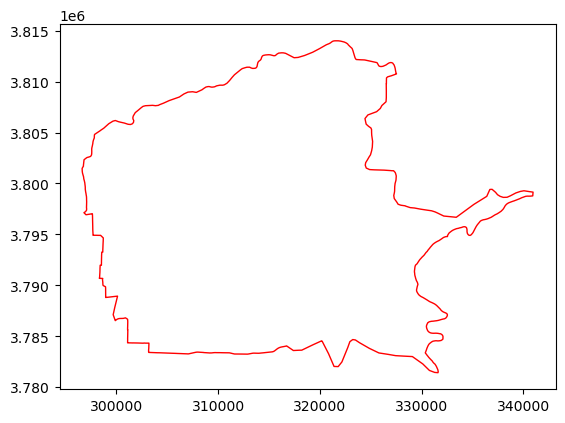

In [13]:
xian_region_merged=postSQL2gpd(table_name='xian_region_merged',**args.db.db_info)   
xian_region_merged.plot(color='none',edgecolor='red');

In [11]:
xian_road=shp2gdf(args.data.road,epsg=args.gi.xian_epsg,boundary=xian_region_merged.geometry[0],encoding='GBK')
gpd2postSQL(xian_road,table_name='xian_road',**args.db.db_info)   

original data info:(2901, 3)
dropna-how=all,result:(2901, 3)
dropna-several rows,result:(2901, 3)
EPSG:32649
__________________________________________________
The GeoDataFrame has been written to the PostgreSQL database.The table name is xian_road.


In [41]:
xian_road.head(3)

,Name,Uid,geometry,mask,pts,pts_wgs84
0,c330b7f768b039602bfc48d0,天台五路-道路,"MULTILINESTRING ((298837.079 3794901.033, 2988...",True,"MULTIPOINT (298837.079 3794901.033, 299096.997...","MULTIPOINT (108.815 34.276, 108.818 34.276, 10..."
1,7463a27c1c1aa5cb09f5eb1b,笃学路-道路,"MULTILINESTRING ((311296.364 3789931.561, 3112...",True,MULTIPOINT (311296.364 3789931.561),MULTIPOINT (108.951 34.233)
2,edbabdf04a242554326212f6,广运东路-道路,"MULTILINESTRING ((317437.538 3799453.408, 3174...",True,"MULTIPOINT (317437.538 3799453.408, 317571.836...","MULTIPOINT (109.016 34.320, 109.017 34.319, 10..."


__________________________________________________
The data has been read from PostgreSQL database. The table name is xian_road.


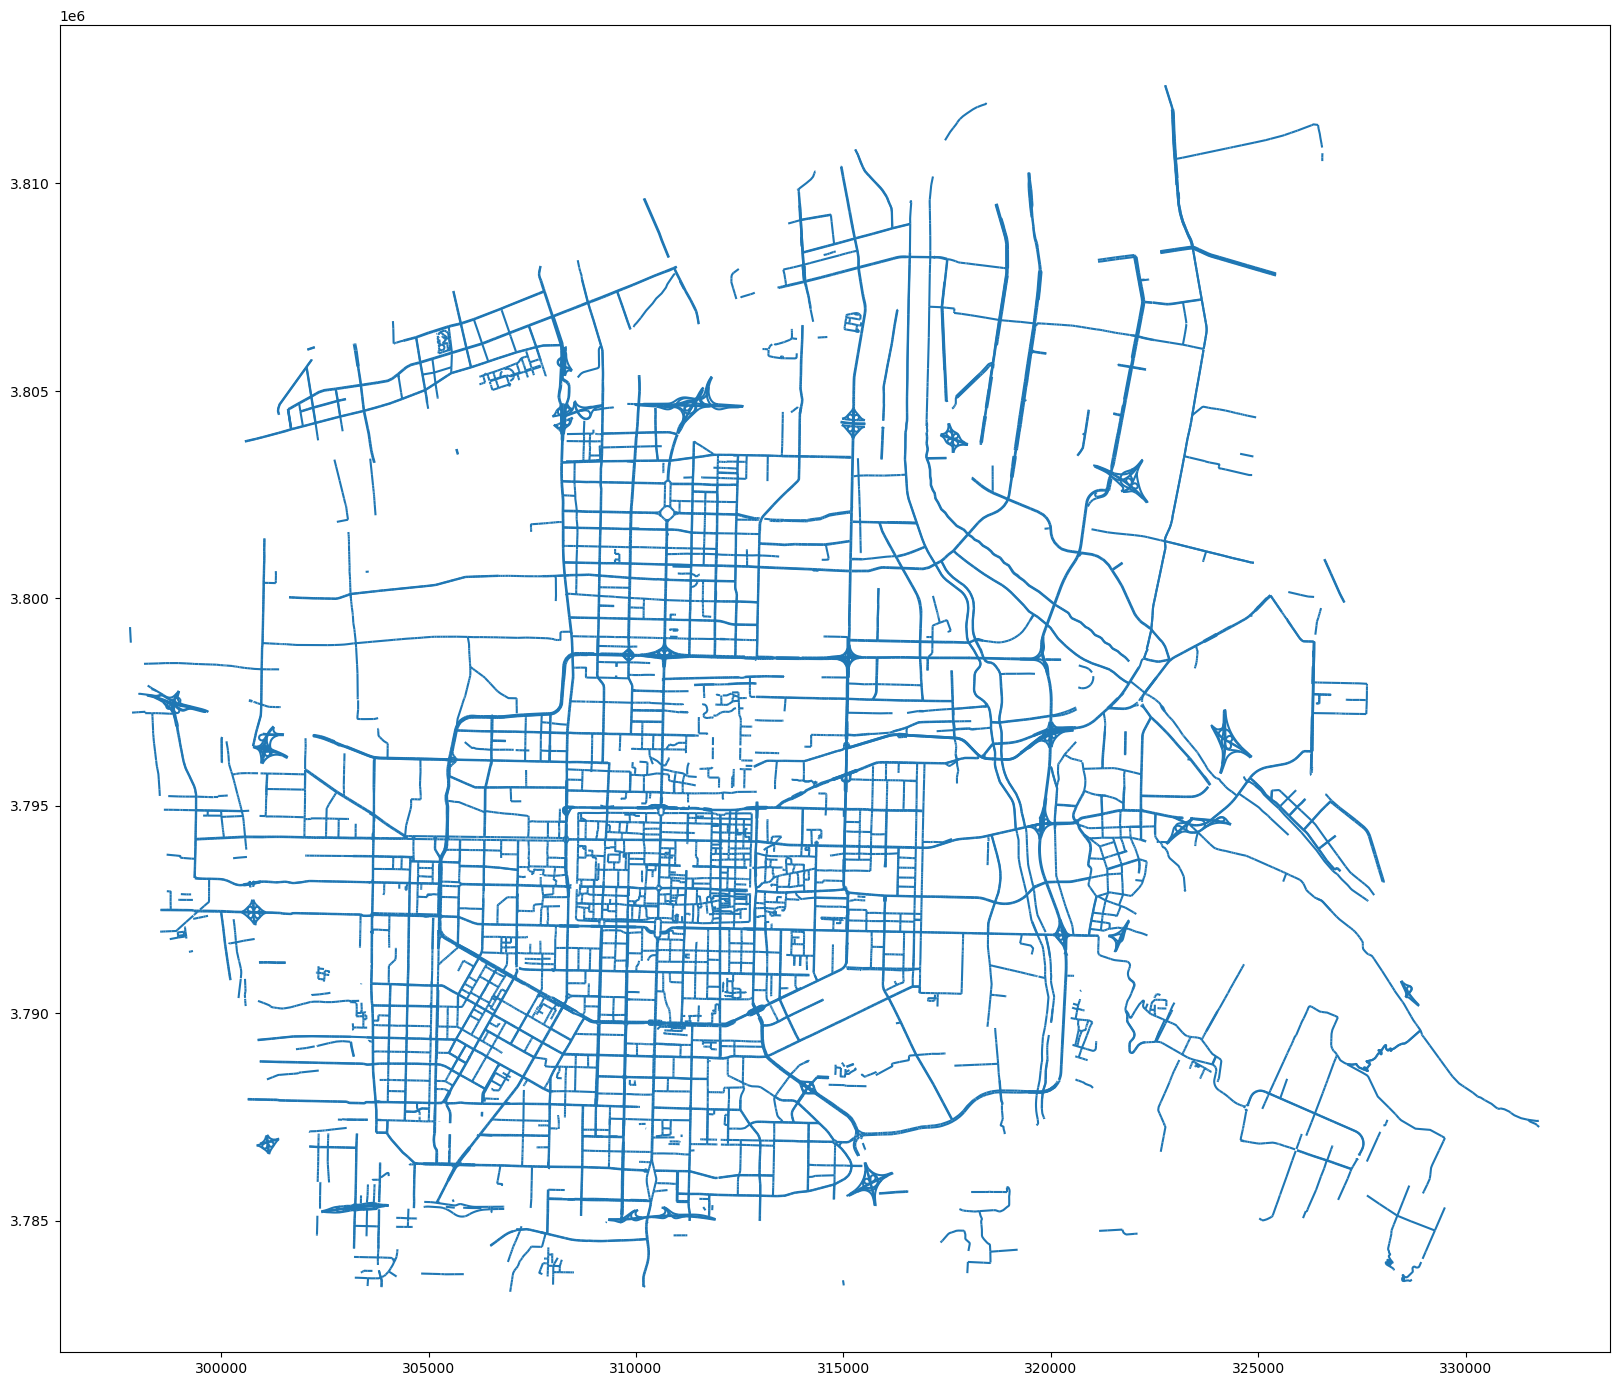

In [25]:
import matplotlib.pyplot as plt

xian_road=postSQL2gpd(table_name='xian_road',**args.db.db_info)   
fig, ax=plt.subplots(figsize=(20,20))
xian_road.plot(ax=ax)
plt.show()

In [18]:
def roads_pts4bsv(roads_gdf,distance=10):
    '''
    给定GeoDataFrame的道路中心线，和采样距离，返回采样点

    Parameters
    ----------
    roads_gdf : GeoDataFrame
        GeoDataFrame的道路中心线.
    distance : numerical value, optional
        采样距离. The default is 10.

    Returns
    -------
    GeoDataFrame
        采样点.

    '''
    from tqdm import tqdm
    import numpy as np
    from shapely.geometry import MultiPoint
    import pyproj
    from shapely.ops import transform
    import geopandas as gpd
    
    tqdm.pandas()    
    def line_pts(line):
        dists=np.arange(0,line.length,distance)
        pts=MultiPoint([line.interpolate(d,normalized=False) for d in dists])
        return pts      
        
    roads_gdf['pts']=roads_gdf.geometry.progress_apply(line_pts)
    
    wgs84=pyproj.CRS('EPSG:4326')
    utm=roads_gdf.crs 
    project=pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform
    roads_gdf['pts_wgs84']=roads_gdf.pts.progress_apply(lambda row:transform(project,row))    
    
    pts_gdf=gpd.GeoDataFrame(roads_gdf[['Name','Uid']],geometry=roads_gdf.pts_wgs84.to_list(),crs=wgs84) 
    
    return pts_gdf

In [27]:
sampling_pts_gdf=roads_pts4bsv(xian_road,200)
gpd2postSQL(sampling_pts_gdf,table_name='sampling_pts',**args.db.db_info)   

100%|██████████| 1430/1430 [00:01<00:00, 735.60it/s]


__________________________________________________
The GeoDataFrame has been written to the PostgreSQL database.The table name is sampling_pts.


In [9]:
sampling_pts_gdf=postSQL2gpd(table_name='sampling_pts',**args.db.db_info) 
sampling_pts_gdf.head(3)

__________________________________________________
The data has been read from PostgreSQL database. The table name is sampling_pts.


,Name,Uid,geometry
0,c330b7f768b039602bfc48d0,天台五路-道路,"MULTIPOINT (108.81479 34.27583, 108.81761 34.2..."
1,7463a27c1c1aa5cb09f5eb1b,笃学路-道路,MULTIPOINT (108.95114 34.23338)
2,edbabdf04a242554326212f6,广运东路-道路,"MULTIPOINT (109.01577 34.32030, 109.01727 34.3..."


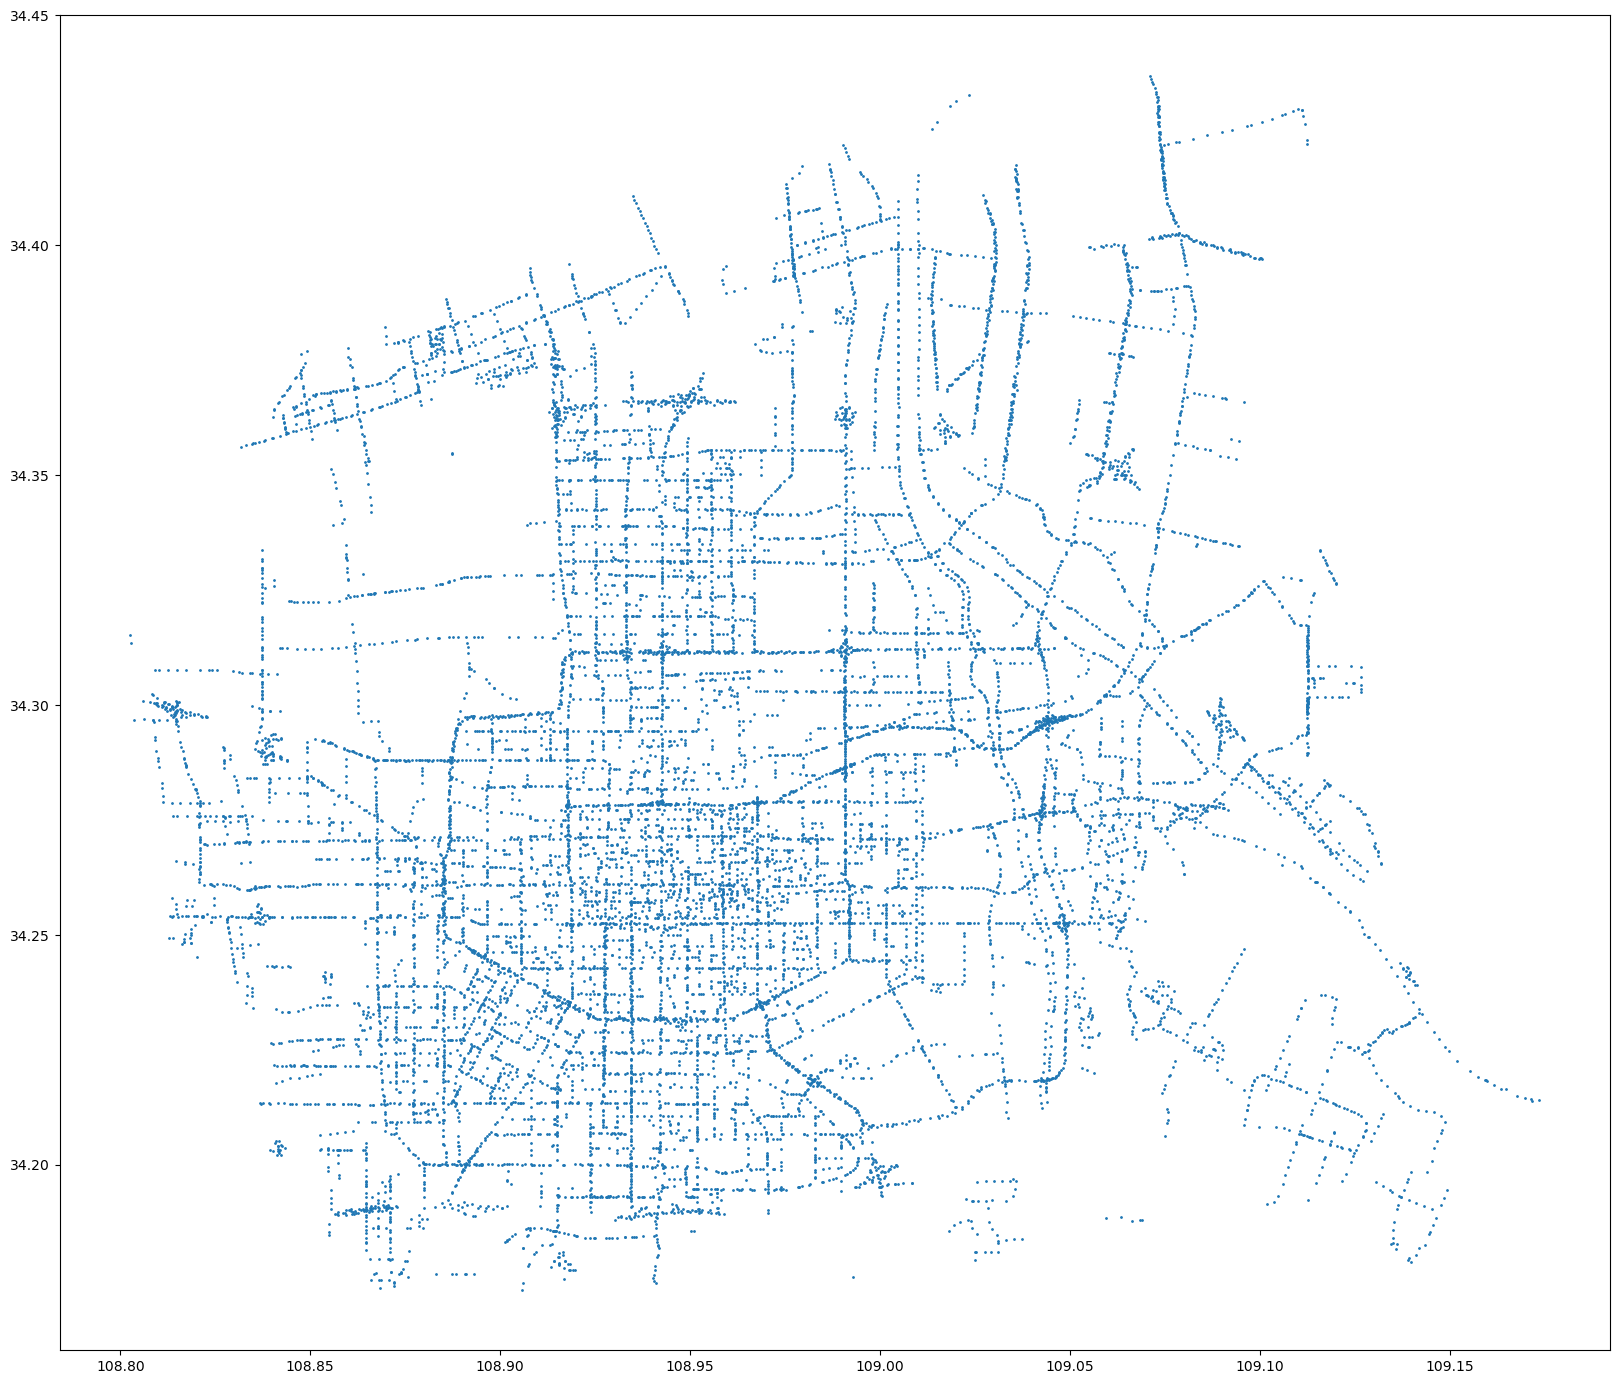

In [29]:
fig, ax=plt.subplots(figsize=(20,20))
sampling_pts_gdf.plot(ax=ax,markersize=1)
plt.show()

In [10]:
def baidu_steetview_crawler(pts_gdf,save_path,ak,save_path_BSV_retrival_info):
    '''
    从百度地图应用中，根据采样点检索下载全景图
    
    Parameters
    ----------
    pts_gdf : GeoDataFrame
        采样点.
    save_path : string
        全景图的保存路径.
    ak : string
        访问应用的AK值，在百度应用中注册申请.
    save_path_BSV_retrival_info : dict
        pickle方式保存下载信息，包括pt_fns-以路径为键，全景图下载地址列表为值；coords-以路径为键，采样点坐标列表为值；
                                 downloadError_idx-错误索引列表.

    Returns
    -------
    coords : dict
        以路径为键，值为采样点坐标列表.
    pts_num : int
        下载全景图的数量.
        
    '''
    import urllib,os
    from tqdm import tqdm
    import pickle
    
    downloadError_idx=[]
    coords={}
    pts_num={}    
    pt_fns={}
    for idx,row in pts_gdf.iterrows():
        pt_coords=[(pt.x,pt.y) for pt in row.geometry.geoms]
        coords[row.Name]=pt_coords
        pts_num[row.Name]=len(pt_coords)
    print("\npts_num={}".format(sum(pts_num.values())))
    
    urlRoot=r"http://api.map.baidu.com/panorama/v2?"
    query_dic={
        'width':'1024',
        'height':'512', 
        'fov':'360',
        'heading':'0',
        'pitch':'0',
        'coordtype':'wgs84ll',
        'ak':ak,
    }   

    for k,v in tqdm(coords.items()):
        pt_fn=[]
        for i,coord in enumerate(v):
            pic_fn=os.path.join(save_path,"{}_{}.jpg".format(k,i))                        
            if not os.path.exists(pic_fn):
                query_dic.update({
                                  'location':str(coord[0])+','+str(coord[1]),
                                 })         
                url=urlRoot+urllib.parse.urlencode(query_dic)
                try:
                    data=urllib.request.urlopen(url)
                    pt_fn.append(pic_fn)
                    with open(pic_fn,'wb') as fp:
                        fp.write(data.read())           
                except:
                    downloadError_idx.append((k,i))
                    print('download_error:{},{}'.format(k,i))
            else:
                print("file existed.")
                
        pt_fns[k]=pt_fn
        
    with open(save_path_BSV_retrival_info["pt_fns"],'wb') as f:
        pickle.dump(pt_fns,f)
    with open(save_path_BSV_retrival_info["coords"],'wb') as f:
        pickle.dump(coords,f)       
    with open(save_path_BSV_retrival_info["downloadError_idx"],'wb') as f:
        pickle.dump(downloadError_idx,f)      
            
    return coords,pts_num

In [ ]:
__C.data.pano_photo='./data/pano_xian/pano_xian_BSV'
__C.data.pano_photo_retrival_info={'pt_fns':'./data/pano_xian/pt_fns_region.pkl','coords':'./data/pano_xian/coords_region.pkl','downloadError_idx':'./data/pano_xian/downloadError_idx_region.pkl'}
ak='rSxNX840wLxwVVhs5RDInfPqegZ12G78'

coords,pts_num=baidu_steetview_crawler(sampling_pts_gdf, args.data.pano_photo, ak, args.data.pano_photo_retrival_info)

---

注释（Notes）：

① 

参考文献（References）:

[1]